## 1. digital filter : separate from each component (base and run-off)

In [1]:
# 구글 드라이브 연결 (파일을 불러오기 위해 필요)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 딥러닝 모형 학습을 위한 기능 import
# -*- coding: utf-8 -*-
%tensorflow_version 1.x
import tensorflow as tf

import pandas as pd
import numpy as np

import datetime
import os
import glob

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.models import Model

from keras import layers
from keras.layers import *
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam, RMSprop

from pickle import dump, load
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

from statsmodels.distributions.empirical_distribution import ECDF
!pip install h5py==2.10.0

%matplotlib inline
print(tf.__version__)


TensorFlow 1.x selected.


Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 2.9 MB 4.2 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


1.15.2


In [3]:
# 구글 드라이브 파일경로(분석자마다 다르게 설정해야함)
path = '/content/drive/MyDrive/data/ten-day-inflow-avg/'

# 파일 읽기, 소양강 유역의 강우 및 유입량 데이터
df_input = pd.read_csv(path + 'soyang.csv')
df_input

,OBSYMD,DAMCD,RF,IQTY
0,19740101,1012110,0.0000,10.000
1,19740102,1012110,0.0000,9.000
2,19740103,1012110,0.0000,4.800
3,19740104,1012110,0.0000,6.100
4,19740105,1012110,0.0000,5.800
...,...,...,...,...
15985,20171007,1012110,0.1613,6.583
15986,20171008,1012110,0.0000,26.463
15987,20171009,1012110,0.0000,6.836
15988,20171010,1012110,1.9319,19.367


In [5]:
Q = df_input['IQTY'].to_numpy().flatten()
Q

array([10.   ,  9.   ,  4.8  , ...,  6.836, 19.367, 54.967])

In [6]:
a=0.998    #%baseflow filter parameter%

R = np.zeros(len(Q))
B = np.zeros(len(Q))
dif = np.zeros(len(Q))

for k in range(0, len(Q)-1):
  # 다음단계의 R은 현재 R * a와 Q의 변화량의 1/2 * (1+a)를 의미함
  #R(k+1)=a.*R(k)+((1+a).*(Q(k+1)-Q(k)))/2;
  R[k+1] = a * R[k] + ((1+a)*(Q[k+1] - Q[k]))/2
  
  # R이 0보다 작다면, 0으로 처리
  # if R(k+1)<0;
  #   R(k+1)=0;
  if R[k+1] < 0:
    R[k+1] = 0
  
  # R이 Q보다 크면 Q로 처리
  # if R(k+1)>Q(k+1);
  #   R(k+1)=Q(k+1);
  if R[k+1] > Q[k+1]:
    R[k+1] = Q[k+1]

  # B는 Q - R
  #B(k+1)=Q(k+1)-R(k+1);
  B[k+1] = Q[k+1] - R[k+1]

  # dif == R
  #dif(k+1)=Q(k+1)-B(k+1);
  dif[k+1] = Q[k+1] - B[k+1]

df = pd.DataFrame({'Q': Q, 'B': B, 'R': R, 'dif': dif, 'RF' : df_input['RF'] })
df

,Q,B,R,dif,RF
0,10.000,0.000000,0.000000,0.000000,0.0000
1,9.000,9.000000,0.000000,0.000000,0.0000
2,4.800,4.800000,0.000000,0.000000,0.0000
3,6.100,4.801300,1.298700,1.298700,0.0000
4,5.800,4.803597,0.996403,0.996403,0.0000
...,...,...,...,...,...
15985,6.583,5.608193,0.974807,0.974807,0.1613
15986,26.463,5.630023,20.832977,20.832977,0.0000
15987,6.836,5.652062,1.183938,1.183938,0.0000
15988,19.367,5.666960,13.700040,13.700040,1.9319


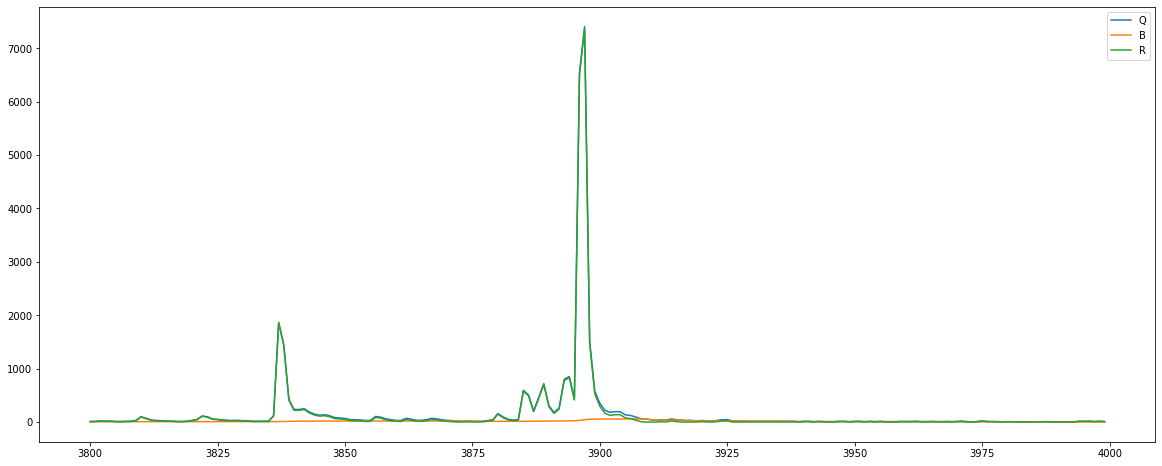

In [7]:
df[['Q', 'B', 'R']][3800:4000].plot(figsize=(20,8))

## 2. Predict Baseflow using LSTM

In [ ]:
# 3차원 입력데이터를 만들기 위해 df_in이라는 데이터프레임으로 복사

df_in = df[['B', 'RF']].copy()

# 값들을 0~1로 Min-Max 정규화 처리함

# define scaler
scaler = MinMaxScaler()
# fit scaler on the training dataset
scaler.fit(df_in.values)
# transform the training dataset
df_in_scaled = pd.DataFrame(scaler.transform(df_in.values), columns = df_in.columns)

# 30에 대해 2개의 변수를 가지는 2차원 데이터셋을 기본 형태로 하는 3차원데이터셋(2차원을 기본으로 하는 배열)을 생성
# y_shift는 이후 1일 후를 예측으로 함

x_range = 30
y_shift = 1
features = df_in_scaled.shape[1]
y_target_column = 'B'

nb_samples = df_in_scaled.shape[0] - (x_range + y_shift - 1)

dataset_X_reshaped = np.zeros((nb_samples, x_range, features))
dataset_y_reshaped = np.zeros((nb_samples, y_shift))

j = 0
for i in range(nb_samples):
  if ((np.isnan(df_in_scaled[i:(i+x_range)].to_numpy()).sum()) > 0) | (np.isnan(df_in[y_target_column][i+x_range+y_shift-1]).sum() > 0) :
    continue 
  dataset_X_reshaped[j] = df_in_scaled[i:(i+x_range)].to_numpy()
  dataset_y_reshaped[j] = df_in[y_target_column][i+x_range+y_shift-1].reshape(-1)
  j = j + 1

dataset_X_reshaped = dataset_X_reshaped[0:j]
dataset_y_reshaped = dataset_y_reshaped[0:j]

print(dataset_X_reshaped.shape)
#print(dataset_X_reshaped)

print(dataset_y_reshaped.shape)
#print(dataset_y_reshaped)

#X_train, X_test, y_train, y_test = train_test_split(dataset_X_reshaped, dataset_y_reshaped, test_size=0.01)

# 15000번째 까지를 훈련데이터셋으로
# 그이후를 테스트데이터셋으로 구성함
X_train = dataset_X_reshaped[0:10000,:,:]
X_val = dataset_X_reshaped[10000:15000,:,:]
X_test = dataset_X_reshaped[15000:,:,:]

y_train = dataset_y_reshaped[0:10000]
y_val = dataset_y_reshaped[10000:15000]
y_test = dataset_y_reshaped[15000:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15960, 30, 2)
(15960, 1)
(10000, 30, 2)
(960, 30, 2)
(10000, 1)
(960, 1)


In [ ]:
# 기본 lstm모형을 생성
# lstm 은 stacked lstm형태로, stacked될 경우 return_sequence = TRUE 옵션 필요
# training=True옵션을 통해 dropout을 이용하여 매번 다른 결과값이 생성됨
# early stopping을 적용하여, 최적의 epoch를 결정함
# 현재 patience는 5로 설정되어 있음

drop_out_rate = 0.05

def base_lstm(X_train, y_train, verbose = 1):
  inputs = Input(shape = (X_train.shape[1],X_train.shape[2]), name='inputs')
  x1 = LSTM(8, return_sequences=True, recurrent_dropout=drop_out_rate)(inputs) 
  x2 = LSTM(8, recurrent_dropout=drop_out_rate)(x1) 
  x3 = Dropout(drop_out_rate)(x2) 
  output = Dense(units = 1, activation='linear', name='OUTPUT')(x3)
  model = Model(inputs=inputs, outputs=output)

  opt = Adam()

  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
  
  epc = 1000
  es = EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)
  
  
  
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=epc, verbose=verbose, callbacks=[es], 
                      batch_size=128)
  return model
 
model_base = base_lstm(X_train, y_train)


Train on 10000 samples, validate on 5000 samples
Epoch 1/1000
10000/10000 [==============================] - 3s 321us/step - loss: 155.1659 - mae: 8.0936 - val_loss: 134.8923 - val_mae: 6.5593
Epoch 2/1000
10000/10000 [==============================] - 2s 233us/step - loss: 125.1512 - mae: 6.9147 - val_loss: 119.6301 - val_mae: 6.3793
Epoch 3/1000
10000/10000 [==============================] - 2s 228us/step - loss: 112.0949 - mae: 6.6057 - val_loss: 113.3086 - val_mae: 6.4287
Epoch 4/1000
10000/10000 [==============================] - 2s 225us/step - loss: 105.3913 - mae: 6.5122 - val_loss: 108.9050 - val_mae: 6.4315
Epoch 5/1000
10000/10000 [==============================] - 2s 233us/step - loss: 96.2361 - mae: 5.7445 - val_loss: 96.3689 - val_mae: 4.9226
Epoch 6/1000
10000/10000 [==============================] - 2s 226us/step - loss: 87.8921 - mae: 5.1032 - val_loss: 89.9723 - val_mae: 4.5802
Epoch 7/1000
10000/10000 [==============================] - 2s 243us/step - loss: 81.4762 

In [ ]:
y_pred = model_base.predict(X_test)
y_obs = y_test

In [ ]:
df_pred = pd.DataFrame({'Date' : df_input['OBSYMD'][15030:].values, 'Obs' : y_obs.flatten(), 'Pred' : y_pred.flatten(), 'RF' : df_input['RF'][15030:].values})
df_pred['Date'] = df_pred['Date'].apply(lambda x: pd.to_datetime(str(int(x)), format='%Y%m%d')) 

df_pred

,Date,Obs,Pred,RF
0,2015-02-25,0.278647,0.410658,0.7594
1,2015-02-26,0.306126,0.417957,0.8506
2,2015-02-27,0.323314,0.435310,0.0000
3,2015-02-28,0.336981,0.444144,0.0000
4,2015-03-01,0.347468,0.451094,0.0000
...,...,...,...,...
955,2017-10-07,5.608193,5.514189,0.1613
956,2017-10-08,5.630023,5.514099,0.0000
957,2017-10-09,5.652062,5.513100,0.0000
958,2017-10-10,5.666960,5.520998,1.9319


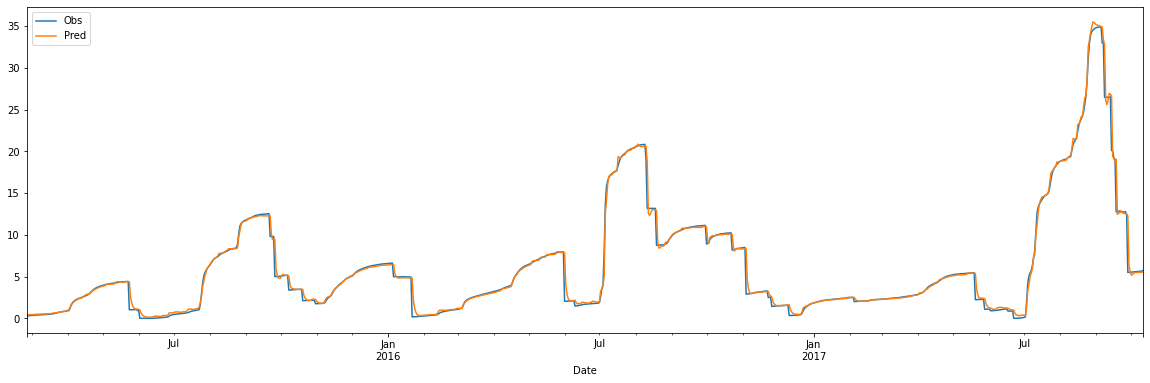

In [ ]:
df_pred[['Date', 'Obs', 'Pred']].set_index('Date').plot(figsize=(20,6))

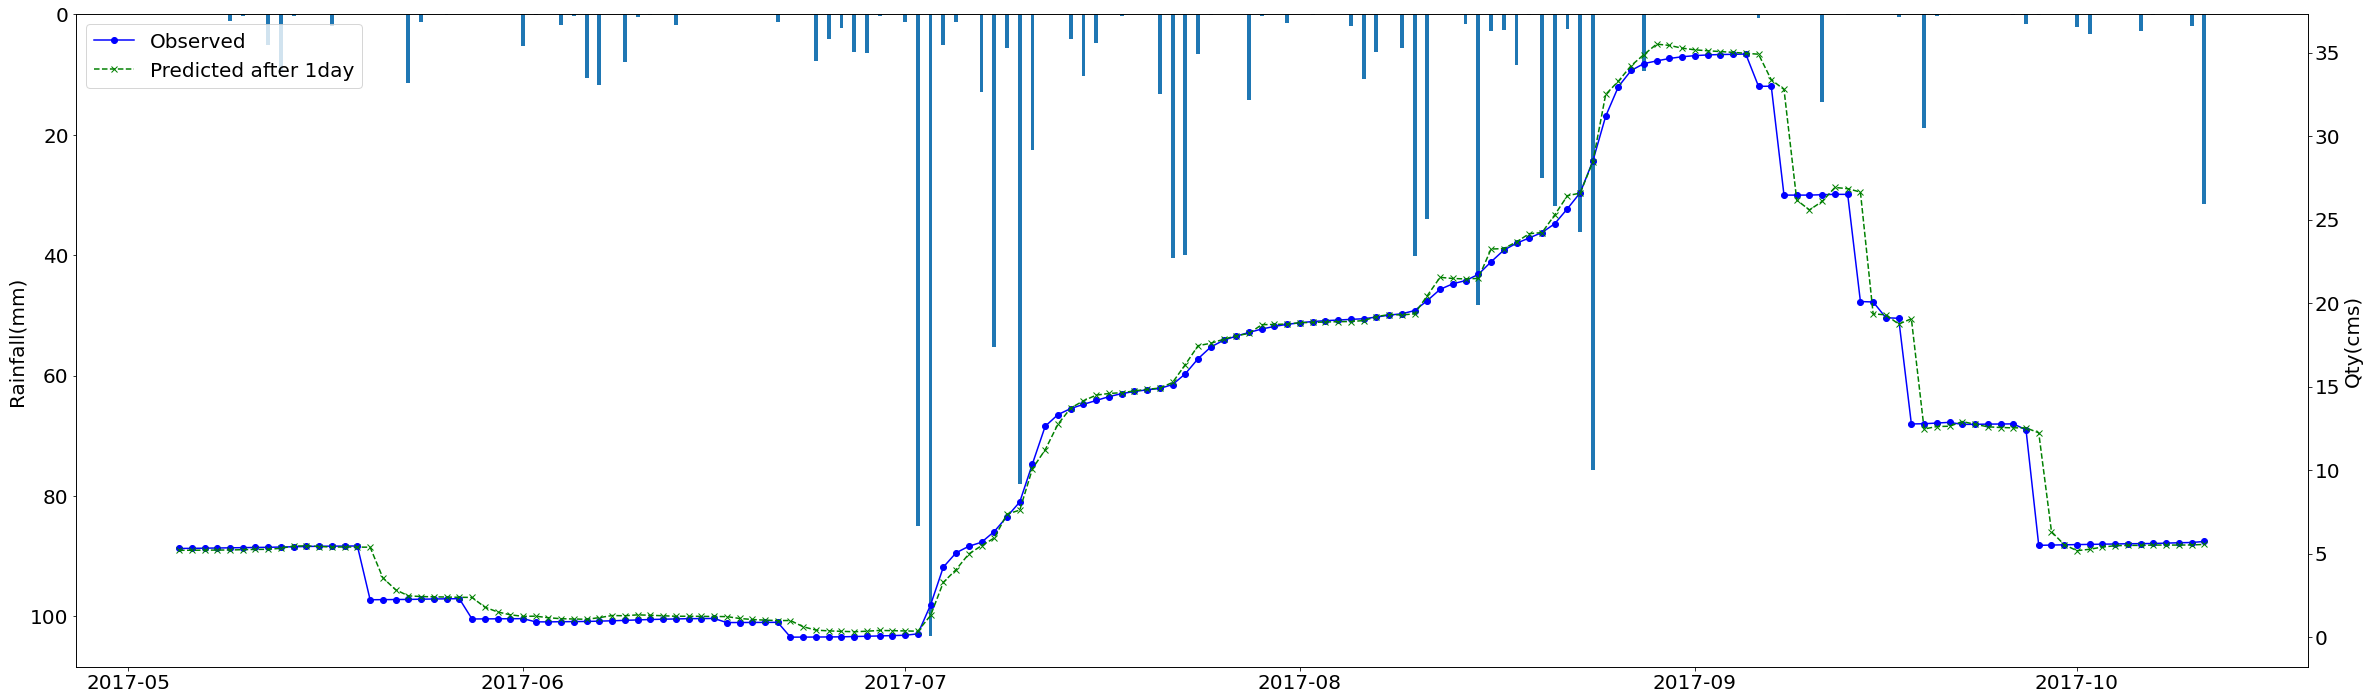

In [ ]:
df_predict = df_pred[800:1000].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.3

ax1.bar(df_predict['Date'], df_predict['RF'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
#ax1.legend(('Rainfall(20204030)','Rainfall(20204020)', 'Rainfall(20214020)', 'Rainfall(20224050)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.legend(('Observed','Predicted after 1day'), loc='upper left', prop={'size': 20})
ax2.set_ylabel('Qty(cms)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

## 3. Predict run-off using LSTM

In [8]:
# 3차원 입력데이터를 만들기 위해 df_in이라는 데이터프레임으로 복사

df_in = df[['R', 'RF']].copy()

# 값들을 0~1로 Min-Max 정규화 처리함

# define scaler
scaler = MinMaxScaler()
# fit scaler on the training dataset
scaler.fit(df_in.values)
# transform the training dataset
df_in_scaled = pd.DataFrame(scaler.transform(df_in.values), columns = df_in.columns)

# 30에 대해 2개의 변수를 가지는 2차원 데이터셋을 기본 형태로 하는 3차원데이터셋(2차원을 기본으로 하는 배열)을 생성
# y_shift는 이후 1일 후를 예측으로 함

x_range = 5
y_shift = 1
features = df_in_scaled.shape[1]
y_target_column = 'R'

nb_samples = df_in_scaled.shape[0] - (x_range + y_shift - 1)

dataset_X_reshaped = np.zeros((nb_samples, x_range, features))
dataset_y_reshaped = np.zeros((nb_samples, y_shift))

j = 0
for i in range(nb_samples):
  if ((np.isnan(df_in_scaled[i:(i+x_range)].to_numpy()).sum()) > 0) | (np.isnan(df_in[y_target_column][i+x_range+y_shift-1]).sum() > 0) :
    continue 
  dataset_X_reshaped[j] = df_in_scaled[i:(i+x_range)].to_numpy()
  dataset_y_reshaped[j] = df_in[y_target_column][i+x_range+y_shift-1].reshape(-1)
  j = j + 1

dataset_X_reshaped = dataset_X_reshaped[0:j]
dataset_y_reshaped = dataset_y_reshaped[0:j]

print(dataset_X_reshaped.shape)
#print(dataset_X_reshaped)

print(dataset_y_reshaped.shape)
#print(dataset_y_reshaped)

#X_train, X_test, y_train, y_test = train_test_split(dataset_X_reshaped, dataset_y_reshaped, test_size=0.01)

# 15000번째 까지를 훈련데이터셋으로
# 그이후를 테스트데이터셋으로 구성함
X_train = dataset_X_reshaped[0:10000,:,:]
X_val = dataset_X_reshaped[10000:15000,:,:]
X_test = dataset_X_reshaped[15000:,:,:]

y_train = dataset_y_reshaped[0:10000]
y_val = dataset_y_reshaped[10000:15000]
y_test = dataset_y_reshaped[15000:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15985, 5, 2)
(15985, 1)
(10000, 5, 2)
(985, 5, 2)
(10000, 1)
(985, 1)


In [9]:
# 기본 lstm모형을 생성
# lstm 은 stacked lstm형태로, stacked될 경우 return_sequence = TRUE 옵션 필요
# training=True옵션을 통해 dropout을 이용하여 매번 다른 결과값이 생성됨
# early stopping을 적용하여, 최적의 epoch를 결정함
# 현재 patience는 5로 설정되어 있음

drop_out_rate = 0.05

def base_lstm(X_train, y_train, verbose = 1):
  inputs = Input(shape = (X_train.shape[1],X_train.shape[2]), name='inputs')
  x = LSTM(64, return_sequences=True)(inputs) 
  x = LSTM(32, return_sequences=True)(x) 
  x = LSTM(16, return_sequences=False)(x) 
  x = Dropout(drop_out_rate)(x) 
  output = Dense(units = 1, activation='linear', name='OUTPUT')(x)
  model = Model(inputs=inputs, outputs=output)

  opt = Adam()

  model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
  
  epc = 1000
  es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
  
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                      epochs=epc, verbose=verbose, callbacks=[es], 
                      batch_size=128)
  return model
 
model_base = base_lstm(X_train, y_train)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 10000 samples, validate on 5000 samples
Epoch 1/1000
10000/10000 [==============================] - 3s 269us/step - loss: 52412.7439 - mae: 57.3510 - val_loss: 55939.2832 - val_mae: 62.1172
Epoch 2/1000
10000/10000 [==============================] - 1s 143us/step - loss: 51937.5092 - mae: 55.3393 - val_loss: 55731.5387 - val_mae: 61.6774
Epoch 3/1000
10000/10000 [==============================] - 1s 145us/step - loss: 51784.0263 - mae: 55.0457 - val_loss: 55566.2428 - val_mae: 61.4324
Epoch 4/1000
10000/10000 [==============================] - 1s 142us/step - loss: 51642.3429 - mae: 54.8763 - val_loss: 55419.3947 - val_mae: 61.2963
Epoch 5/1000
10000/10000 [==============================] - 1s 145us/step - loss: 51518.3299 - mae: 54.8042 - val_loss: 55281.9562 - val_mae: 61.2419
Epoch 6/1000
10000/10000 [==============================] - 1s 143us/step - loss: 51400.7188 - mae: 54.8074 - val_loss:

In [10]:
y_pred = model_base.predict(X_test)
y_obs = y_test

In [16]:
len(y_pred.flatten())

985

In [17]:
df_pred = pd.DataFrame({'Date' : df_input['OBSYMD'][15005:].values, 'Obs' : y_obs.flatten(), 'Pred' : y_pred.flatten(), 'RF' : df_input['RF'][15005:].values})
df_pred['Date'] = df_pred['Date'].apply(lambda x: pd.to_datetime(str(int(x)), format='%Y%m%d')) 

df_pred

,Date,Obs,Pred,RF
0,2015-01-31,0.128469,4.404547,0.0000
1,2015-02-01,0.766573,4.778139,0.0000
2,2015-02-02,4.635166,4.765486,0.0000
3,2015-02-03,0.668857,4.415600,0.0000
4,2015-02-04,0.649537,4.839186,0.0000
...,...,...,...,...
980,2017-10-07,0.974807,6.408861,0.1613
981,2017-10-08,20.832977,9.105827,0.0000
982,2017-10-09,1.183938,6.176830,0.0000
983,2017-10-10,13.700040,7.606388,1.9319


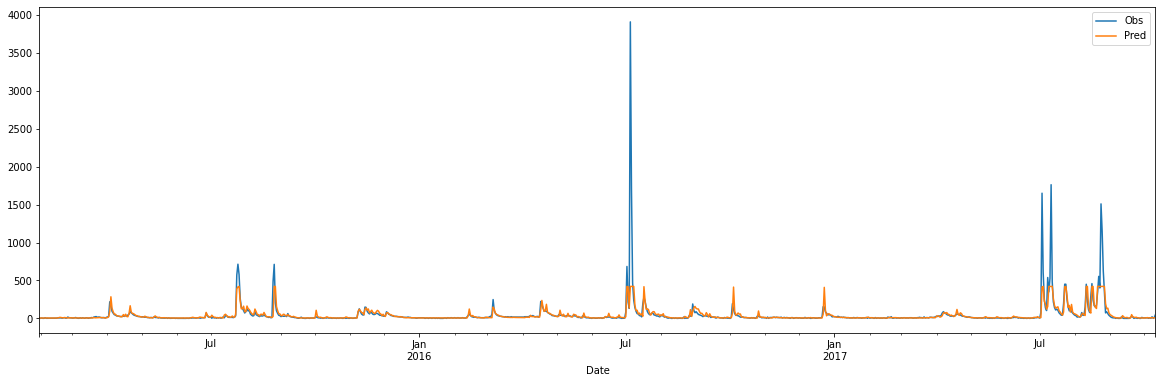

In [18]:
df_pred[['Date', 'Obs', 'Pred']].set_index('Date').plot(figsize=(20,6))

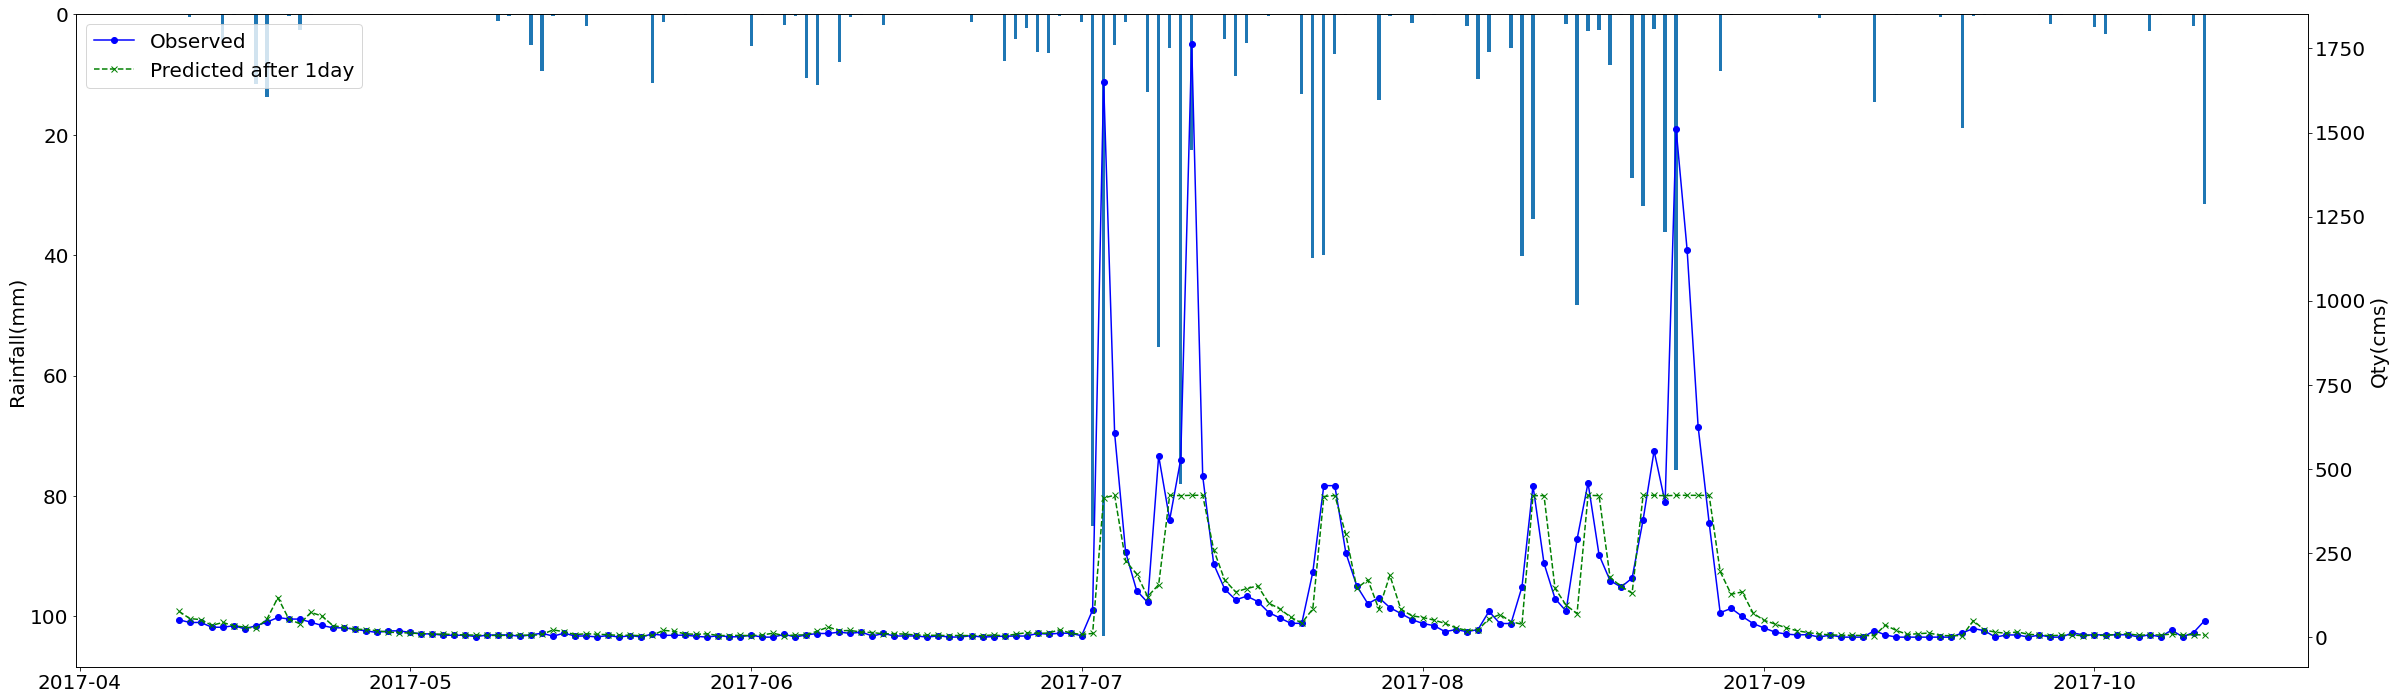

In [19]:
df_predict = df_pred[800:1000].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.3

ax1.bar(df_predict['Date'], df_predict['RF'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
#ax1.legend(('Rainfall(20204030)','Rainfall(20204020)', 'Rainfall(20214020)', 'Rainfall(20224050)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.legend(('Observed','Predicted after 1day'), loc='upper left', prop={'size': 20})
ax2.set_ylabel('Qty(cms)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

In [28]:
r2=r2_score(df_pred['Obs'].to_numpy(), df_pred['Pred'].to_numpy())
r2

0.388029509152386

## other ML algorithm

In [20]:
# 시계열에 대한 Lag변수를 만들기 위한 함수
def buildLaggedFeatures(s,lag=2,dropna=True):

# Builds a new DataFrame to facilitate regressing over all possible lagged features
  if type(s) is pd.DataFrame:
    new_dict={}
    for col_name in s:
        new_dict[col_name]=s[col_name]
        # create lagged Series
        for l in range(1,lag+1):
            new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
    res=pd.DataFrame(new_dict,index=s.index)

  elif type(s) is pd.Series:
    the_range=range(lag+1)
    res=pd.concat([s.shift(i) for i in the_range],axis=1)
    res.columns=['lag_%d' %i for i in the_range]
  else:
    print('Only works for DataFrame or Series')
    return None
  if dropna:
    return res.dropna()
  else:
    return res 

In [41]:
# 강우에 대한 5일간의 Lag변수 생성
rf_5 = buildLaggedFeatures(df[['RF']],30)
rf_5

,RF,RF_lag1,RF_lag2,RF_lag3,RF_lag4,RF_lag5,RF_lag6,RF_lag7,RF_lag8,RF_lag9,...,RF_lag21,RF_lag22,RF_lag23,RF_lag24,RF_lag25,RF_lag26,RF_lag27,RF_lag28,RF_lag29,RF_lag30
30,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
31,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
32,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
33,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
34,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15985,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,0.0000,0.0679,...,0.0000,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000,0.0000,0.0000,0.0000
15986,0.0000,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,0.0000,...,0.4728,0.0000,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000,0.0000,0.0000
15987,0.0000,0.0000,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,...,0.0000,0.4728,0.0000,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000,0.0000
15988,1.9319,0.0000,0.0000,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,...,18.9202,0.0000,0.4728,0.0000,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000


In [49]:
# surface flow 유입량에 대한 30일간의 Lag변수 생성
r_5 = buildLaggedFeatures(df[['R']],30)
r_5

,R,R_lag1,R_lag2,R_lag3,R_lag4,R_lag5,R_lag6,R_lag7,R_lag8,R_lag9,...,R_lag21,R_lag22,R_lag23,R_lag24,R_lag25,R_lag26,R_lag27,R_lag28,R_lag29,R_lag30
30,2.799698,2.905409,2.811131,0.414360,0.415190,0.215822,1.917958,3.523405,6.833772,4.244862,...,0.000000,1.373108,1.976461,4.583027,3.891510,0.996403,1.298700,0.000000,0.000000,0.000000
31,2.694199,2.799698,2.905409,2.811131,0.414360,0.415190,0.215822,1.917958,3.523405,6.833772,...,1.598400,0.000000,1.373108,1.976461,4.583027,3.891510,0.996403,1.298700,0.000000,0.000000
32,0.191310,2.694199,2.799698,2.905409,2.811131,0.414360,0.415190,0.215822,1.917958,3.523405,...,0.995803,1.598400,0.000000,1.373108,1.976461,4.583027,3.891510,0.996403,1.298700,0.000000
33,2.688428,0.191310,2.694199,2.799698,2.905409,2.811131,0.414360,0.415190,0.215822,1.917958,...,2.991812,0.995803,1.598400,0.000000,1.373108,1.976461,4.583027,3.891510,0.996403,1.298700
34,3.282451,2.688428,0.191310,2.694199,2.799698,2.905409,2.811131,0.414360,0.415190,0.215822,...,2.885928,2.991812,0.995803,1.598400,0.000000,1.373108,1.976461,4.583027,3.891510,0.996403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15985,0.974807,7.264054,0.726052,7.022809,7.064911,6.932923,6.814684,6.389902,12.838149,0.000000,...,0.000000,0.000000,0.000000,0.000000,6.468194,19.578266,0.046911,0.020979,0.000000,6.493500
15986,20.832977,0.974807,7.264054,0.726052,7.022809,7.064911,6.932923,6.814684,6.389902,12.838149,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.468194,19.578266,0.046911,0.020979,0.000000
15987,1.183938,20.832977,0.974807,7.264054,0.726052,7.022809,7.064911,6.932923,6.814684,6.389902,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.468194,19.578266,0.046911,0.020979
15988,13.700040,1.183938,20.832977,0.974807,7.264054,0.726052,7.022809,7.064911,6.932923,6.814684,...,12.841146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.468194,19.578266,0.046911


In [50]:
# 5일간의 lag된 강우와, 5일째 유입량을 변수로 만듬
# RF(t-1) ~ RF(t-5)으로  Q(t)를 예측하는 문제로 설정함
data = pd.concat([rf_5.drop(columns=['RF']), r_5['R']], axis=1)
data = data.reset_index(drop=True)
data

,RF_lag1,RF_lag2,RF_lag3,RF_lag4,RF_lag5,RF_lag6,RF_lag7,RF_lag8,RF_lag9,RF_lag10,...,RF_lag22,RF_lag23,RF_lag24,RF_lag25,RF_lag26,RF_lag27,RF_lag28,RF_lag29,RF_lag30,R
0,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,0.0000,8.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.799698
1,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.694199
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.191310
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.688428
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.282451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15955,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,0.0000,0.0679,1.6041,...,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000,0.0000,0.0000,0.0000,0.974807
15956,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,0.0000,0.0679,...,0.0000,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000,0.0000,0.0000,20.832977
15957,0.0000,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,0.0000,...,0.4728,0.0000,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000,0.0000,1.183938
15958,0.0000,0.0000,0.1613,2.7985,0.0000,0.0000,0.0000,3.2480,2.0366,0.0000,...,0.0000,0.4728,0.0000,0.0000,0.0000,0.0655,0.0000,14.5532,0.0000,13.700040


In [51]:
# train dataset과 test dataset으로 분리
train = data[:15000]
test = data[15000:]

In [52]:
# 사용할 머신러닝 알고리즘 import

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import SVR

from sklearn.metrics import r2_score


In [53]:
# 독립변수와 종속변수 분리

X_train = train.drop(['R'], axis = 1)
y_train = train['R']
X_test = test[X_train.columns]
y_test = test['R']

In [54]:
# 선형회귀에 대한 예측

m = LinearRegression()
m.fit(X_train,y_train)
pred=m.predict(X_test)
r2=r2_score(y_test.to_numpy(), pred)
r2

0.4980443702976902

In [55]:
# 선형회귀, Lasso, Ridge, SVR, Randomforest, LGBM 모델을 설정하고, 위와 동일하게 반복 수행하며
# test dataset에 대한 r-squared 계산

models=[LinearRegression(), 
        Lasso(random_state=0), 
        Ridge(random_state=0),
        SVR(kernel='poly', degree = 2), 
        RandomForestRegressor(random_state=0), 
        LGBMRegressor(random_state=0)]
     
model_names=['LinearRegression',
             'Lasso', 
             'Ridge',
             'SVR_poly',
             'RandomForestRegressor',
             'LGBMRegressor']

r2_list=[]

for model in range (len(models)):
  print(model_names[model])
  clf=models[model]
  clf.fit(X_train,y_train)
  pred=clf.predict(X_test)
  r2=r2_score(y_test.to_numpy(), pred)
  print(r2)
  r2_list.append(r2)
  

LinearRegression
0.4980443702976902
Lasso
0.4982334134941131
Ridge
0.4980444398709065
SVR_poly
0.38032003703043593
RandomForestRegressor
0.554187161892068
LGBMRegressor
0.5287962637313384


In [56]:
m=RandomForestRegressor(random_state=0)
m.fit(X_train,y_train)
pred=m.predict(X_test)
r2=r2_score(y_test.to_numpy(), pred)
r2

0.554187161892068

In [57]:
df_pred = pd.DataFrame({'Date' : df_input['OBSYMD'][15030:].values, 'Obs' : y_test, 'Pred' : pred.flatten(), 'RF' : df_input['RF'][15030:].values})
df_pred['Date'] = df_pred['Date'].apply(lambda x: pd.to_datetime(str(int(x)), format='%Y%m%d')) 

df_pred

,Date,Obs,Pred,RF
15000,2015-02-25,17.139353,15.868866,0.7594
15001,2015-02-26,10.311874,13.298604,0.8506
15002,2015-02-27,6.858686,13.897637,0.0000
15003,2015-02-28,6.795019,13.389379,0.0000
15004,2015-03-01,3.681532,7.908676,0.0000
...,...,...,...,...
15955,2017-10-07,0.974807,16.664575,0.1613
15956,2017-10-08,20.832977,10.950814,0.0000
15957,2017-10-09,1.183938,8.842712,0.0000
15958,2017-10-10,13.700040,15.303106,1.9319


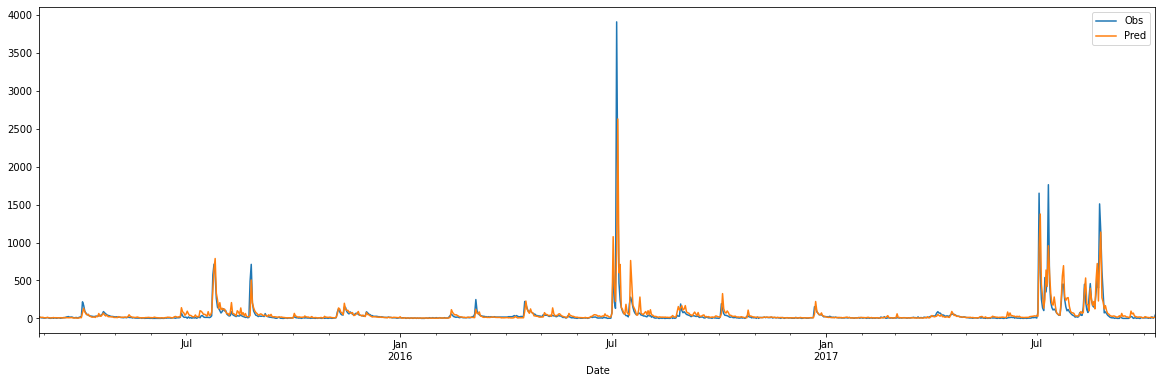

In [58]:
df_pred[['Date', 'Obs', 'Pred']].set_index('Date').plot(figsize=(20,6))

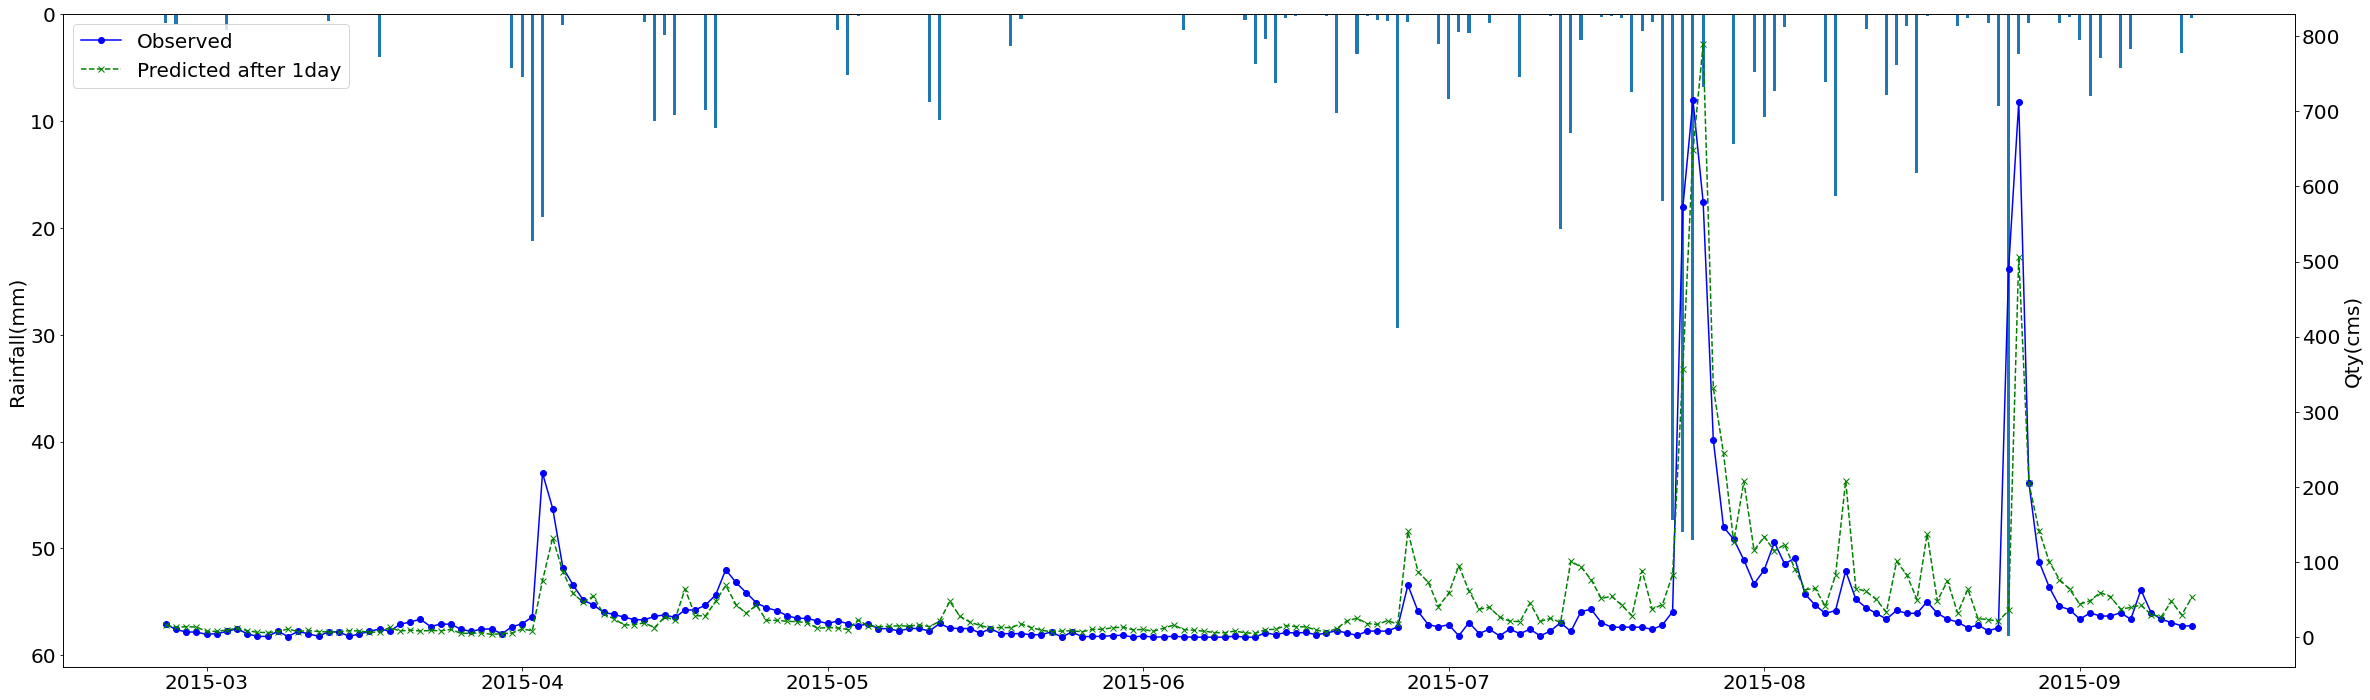

In [59]:
df_predict = df_pred[0:200].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.3

ax1.bar(df_predict['Date'], df_predict['RF'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
#ax1.legend(('Rainfall(20204030)','Rainfall(20204020)', 'Rainfall(20214020)', 'Rainfall(20224050)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.legend(('Observed','Predicted after 1day'), loc='upper left', prop={'size': 20})
ax2.set_ylabel('Qty(cms)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

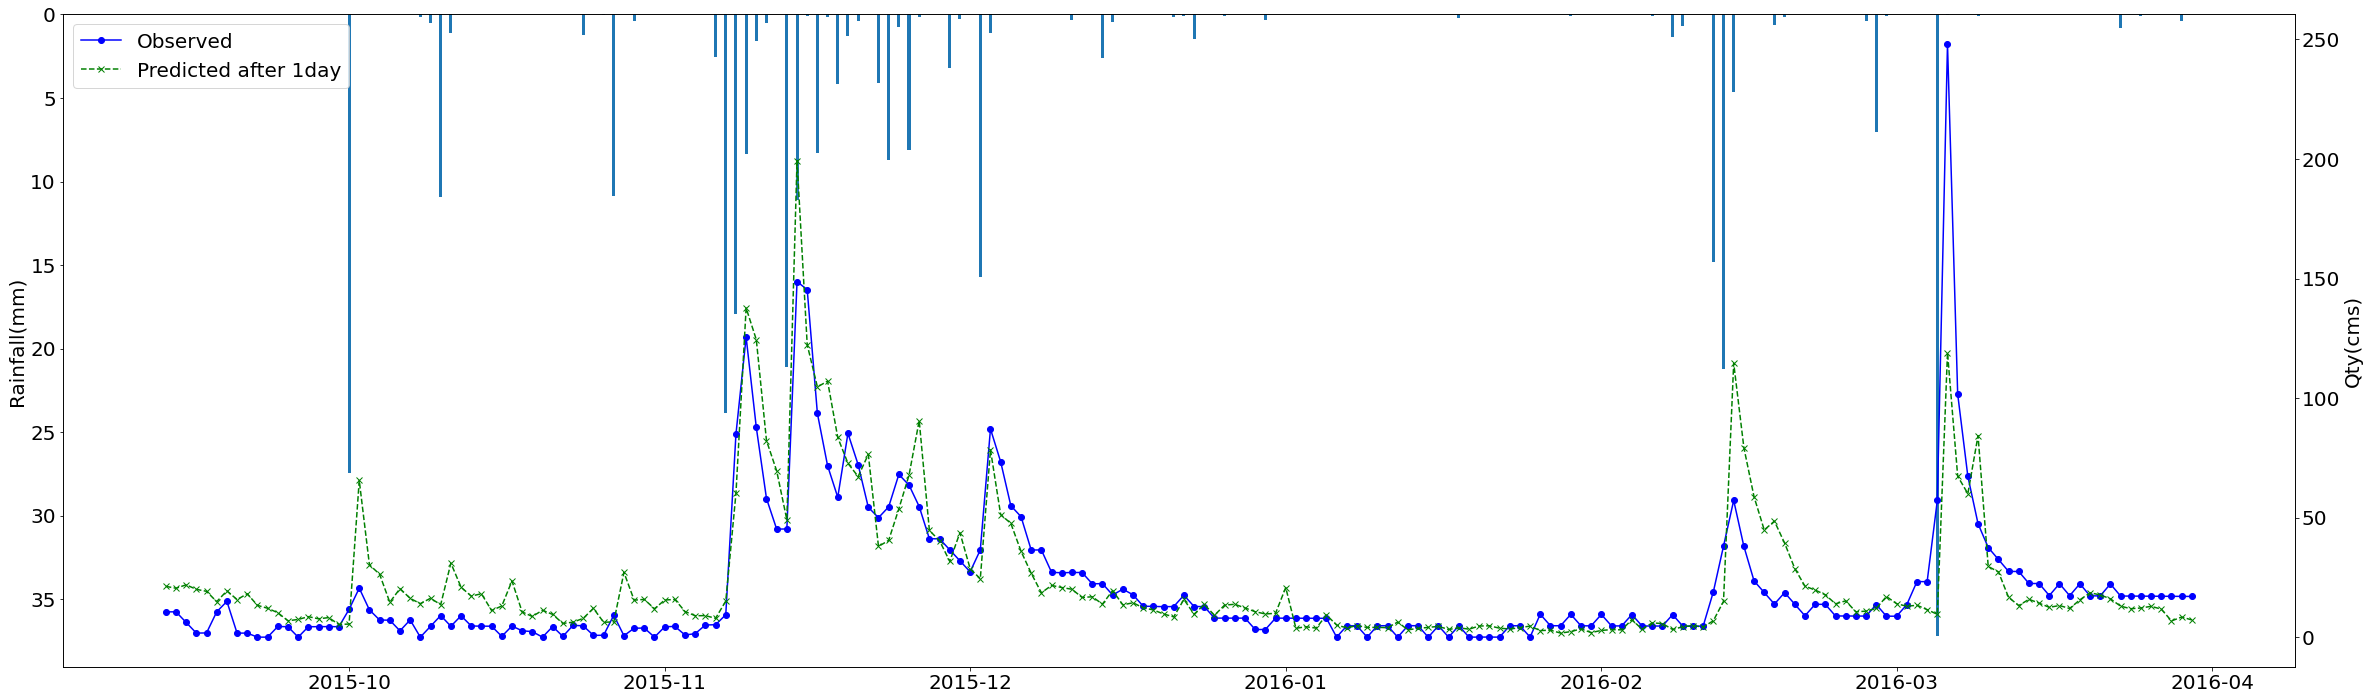

In [60]:
df_predict = df_pred[200:400].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.3

ax1.bar(df_predict['Date'], df_predict['RF'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
#ax1.legend(('Rainfall(20204030)','Rainfall(20204020)', 'Rainfall(20214020)', 'Rainfall(20224050)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.legend(('Observed','Predicted after 1day'), loc='upper left', prop={'size': 20})
ax2.set_ylabel('Qty(cms)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

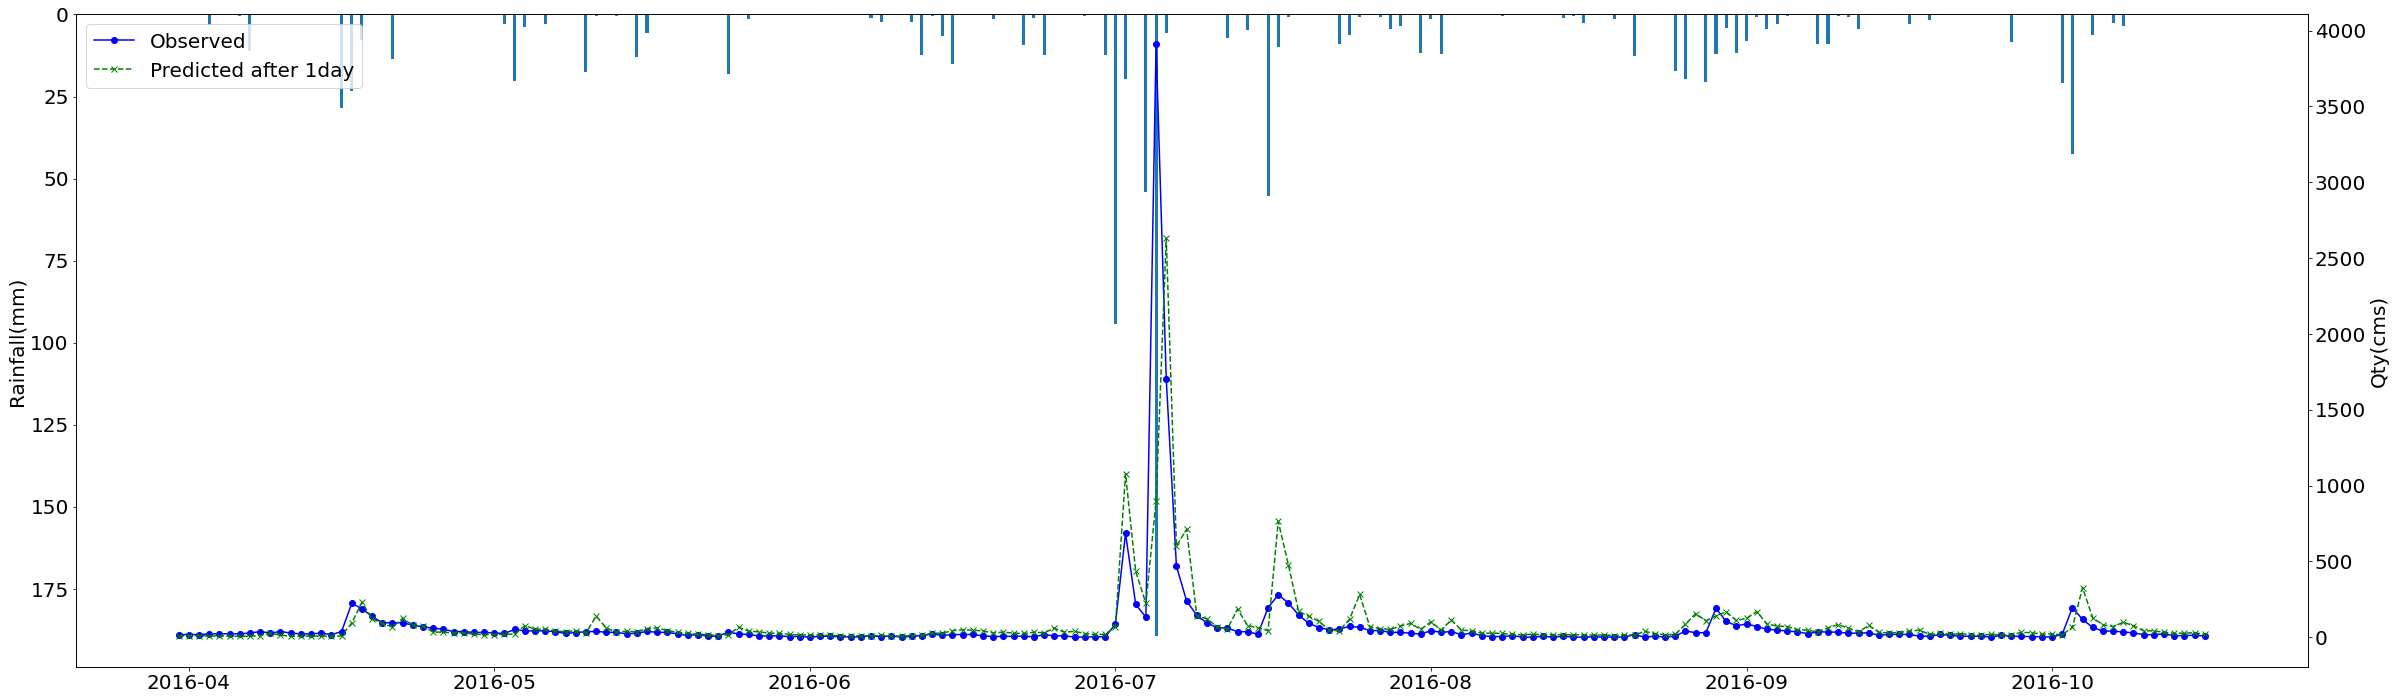

In [61]:
df_predict = df_pred[400:600].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.3

ax1.bar(df_predict['Date'], df_predict['RF'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
#ax1.legend(('Rainfall(20204030)','Rainfall(20204020)', 'Rainfall(20214020)', 'Rainfall(20224050)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.legend(('Observed','Predicted after 1day'), loc='upper left', prop={'size': 20})
ax2.set_ylabel('Qty(cms)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

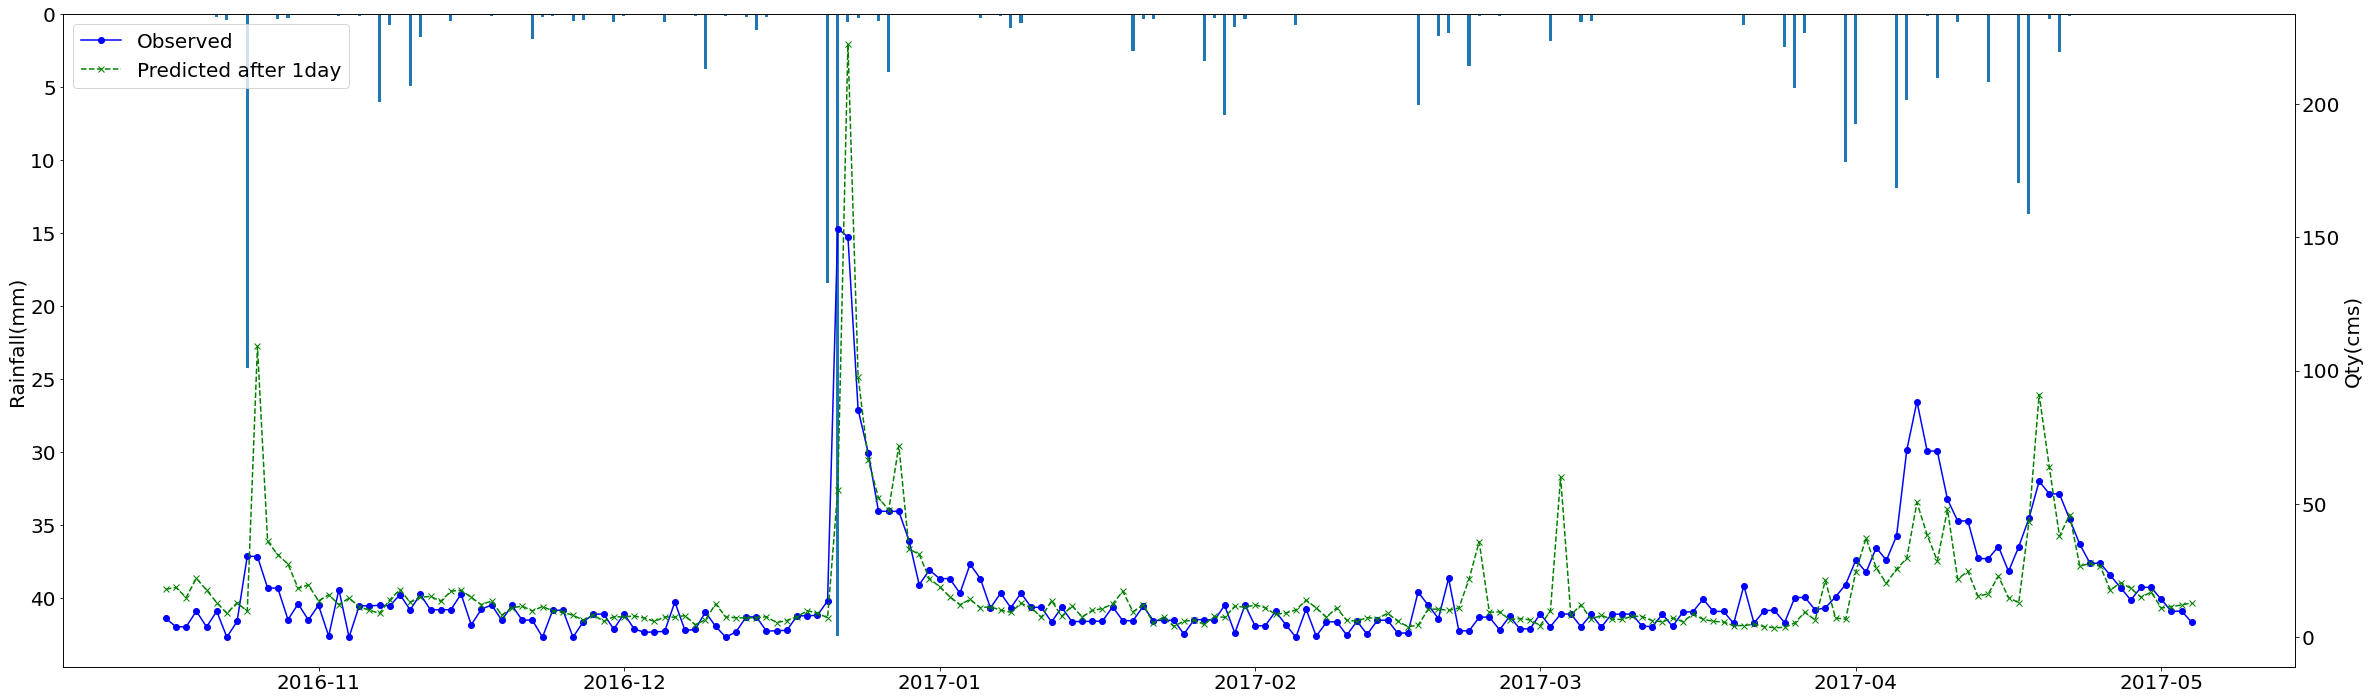

In [62]:
df_predict = df_pred[600:800].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.3

ax1.bar(df_predict['Date'], df_predict['RF'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
#ax1.legend(('Rainfall(20204030)','Rainfall(20204020)', 'Rainfall(20214020)', 'Rainfall(20224050)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.legend(('Observed','Predicted after 1day'), loc='upper left', prop={'size': 20})
ax2.set_ylabel('Qty(cms)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

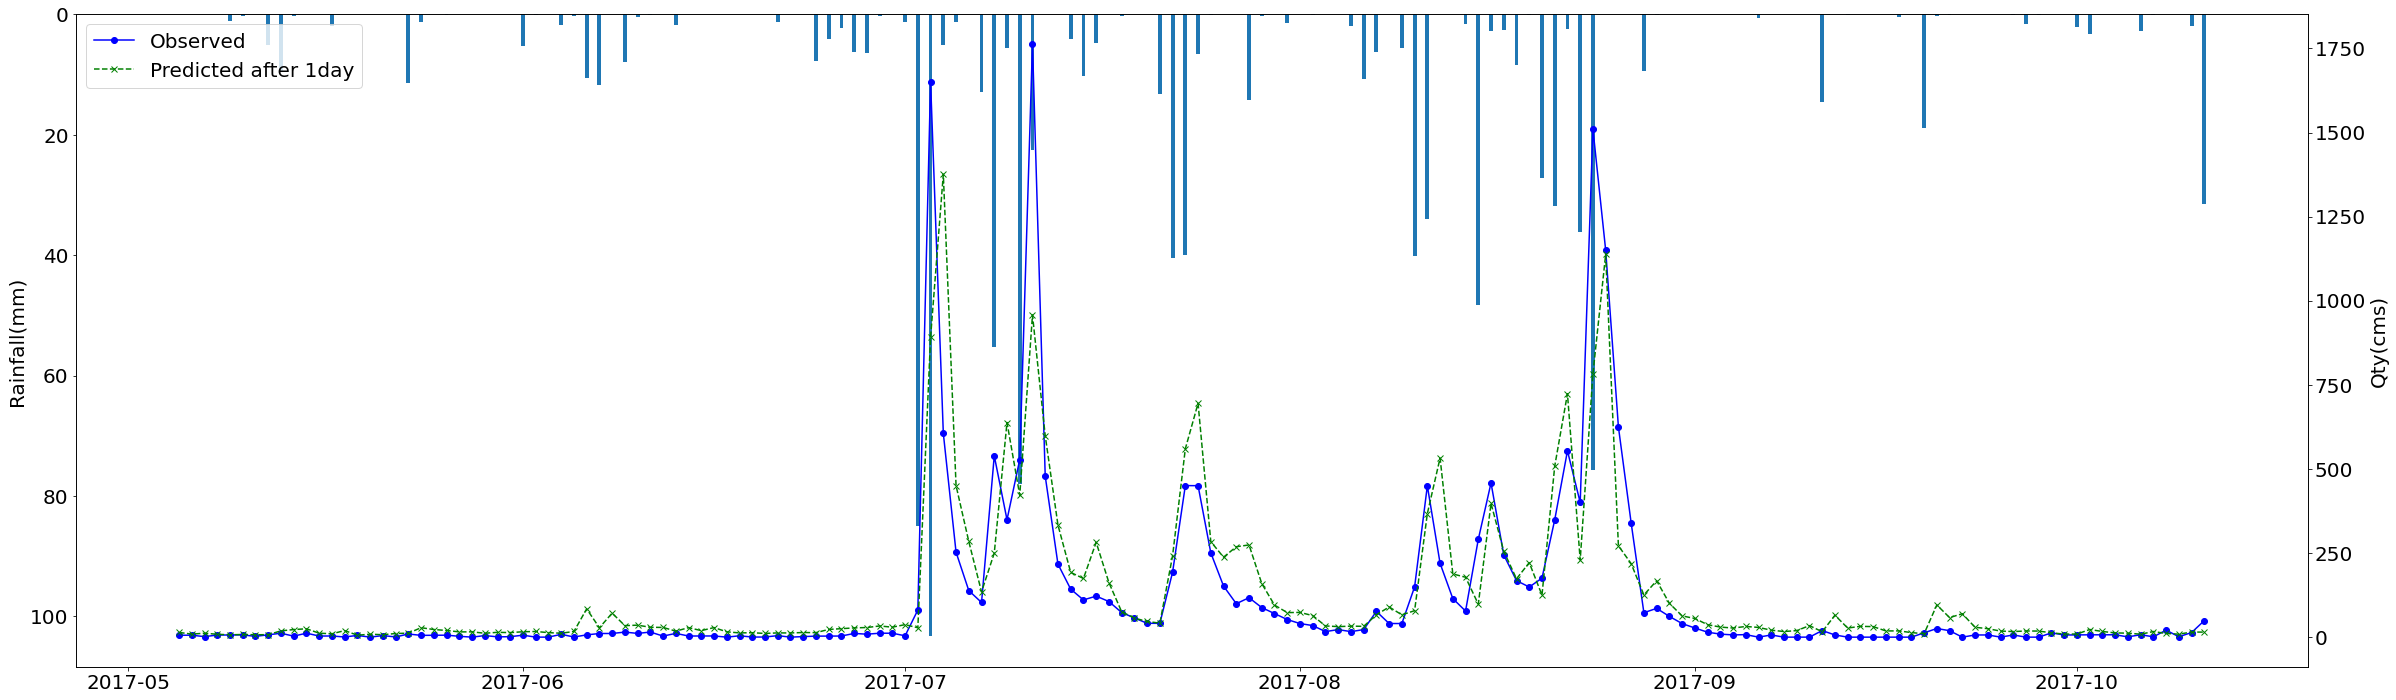

In [63]:
df_predict = df_pred[800:1000].copy()

fig, ax1 = plt.subplots(figsize=(40,12))

ax2 = ax1.twinx()
width = 0.3

ax1.bar(df_predict['Date'], df_predict['RF'], width=width)
ax1.set_ylabel('Rainfall(mm)', fontsize=20)
#ax1.legend(('Rainfall(20204030)','Rainfall(20204020)', 'Rainfall(20214020)', 'Rainfall(20224050)'), loc='upper left', prop={'size': 20})
ax1.invert_yaxis()

ax2.plot(df_predict['Date'], df_predict['Obs'], 'b-', marker='o')
ax2.plot(df_predict['Date'], df_predict['Pred'], 'g-', marker='x', linestyle='dashed')
ax2.legend(('Observed','Predicted after 1day'), loc='upper left', prop={'size': 20})
ax2.set_ylabel('Qty(cms)', fontsize=20)
 
# Set tick font size
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels() ):
	label.set_fontsize(20)

## 4. Combine 2 & 3